# Clear Pycache

In [1]:
import shutil
import os


directory_list = ['', "Data", "Models", "Training", "Notebooks", "Visualizer", "Models/DeepLabV3_Plus", "Config"]
for directory in directory_list:
    directory = os.path.join("..", directory, "__pycache__")
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Removed {directory}")

Removed ..\Data\__pycache__
Removed ..\Models\__pycache__
Removed ..\Training\__pycache__
Removed ..\Models/DeepLabV3_Plus\__pycache__
Removed ..\Config\__pycache__


# Imports

In [2]:
import sys
sys.path.append('../')

import torch
import torch.nn as nn
import sys
import torch.optim as optim

from Models import UNet
from Data.dataset import UnetDataSet
from Data.dataloader import get_loaders
from Data.transforms import get_train_transforms, get_val_transforms

from Training.checkpoint import load_checkpoint, save_checkpoint, save_checkpoint


# Hyperparameters

In [3]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 105
NUM_WORKERS = 8
IMAGE_HEIGHT = 128
IMAGE_WIDTH = IMAGE_HEIGHT
MAX_BATCH = None
PIN_MEMORY = True
LOAD_MODEL = True
NUM_CLASSES = 151

# Dataset Directories

In [4]:
TRAIN_IMG_DIR = r"I:\Downloads\Compressed\ADE20K_SemSeg\Preprocessed\train_images"
TRAIN_MASK_DIR = r"I:\Downloads\Compressed\ADE20K_SemSeg\Preprocessed\train_masks"
VAL_IMG_DIR = r"I:\Downloads\Compressed\ADE20K_SemSeg\Preprocessed\val_images"
VAL_MASK_DIR = r"I:\Downloads\Compressed\ADE20K_SemSeg\Preprocessed\val_masks"
CHECKPOINT_FIlE = "../Checkpoints/adek20_checkpoint_unet.pth"

# Load Model

In [5]:
model = UNet(NUM_CLASSES).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
start_epoch = 0

try:
    if LOAD_MODEL:
        start_epoch = load_checkpoint(ckpt_file=CHECKPOINT_FIlE, model=model, optimizer=optimizer)
except Exception as e:
    print(f"Error loading checkpoint: {str(e)}")
    start_epoch = 0

train_ds = UnetDataSet(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=get_train_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))
val_ds = UnetDataSet(VAL_IMG_DIR, VAL_MASK_DIR, transform=get_val_transforms(IMAGE_HEIGHT, IMAGE_WIDTH))

train_loader, val_loader = get_loaders(
    train_ds,
    val_ds,
    BATCH_SIZE,
    NUM_WORKERS,
    PIN_MEMORY,
)

Error loading checkpoint: [Errno 2] No such file or directory: '../Checkpoints/adek20_checkpoint_unet.pth'


(128, 128, 3)


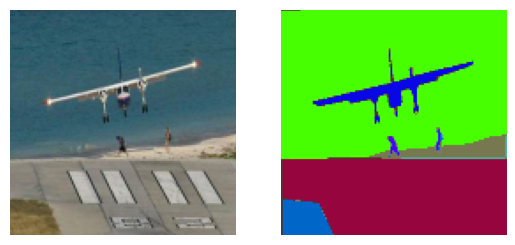

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from Data.preprocessing_adek20 import decode_mask

image, mask = train_ds[0]

# tensor to numpy

image = image.permute(1, 2, 0).numpy().astype(np.uint8)
mask = decode_mask(mask).astype(np.uint8)

print(mask.shape)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')

plt.show()


# Training Loop

Starting from epoch 1


Epoch 1: 100%|██████████| 1599/1599 [13:09<00:00,  2.03batch/s, Loss=2.42, Pixel Accuracy=0.289, mIoU=0.0101]   


=> Epoch 1 is complete
=> Saving checkpoint


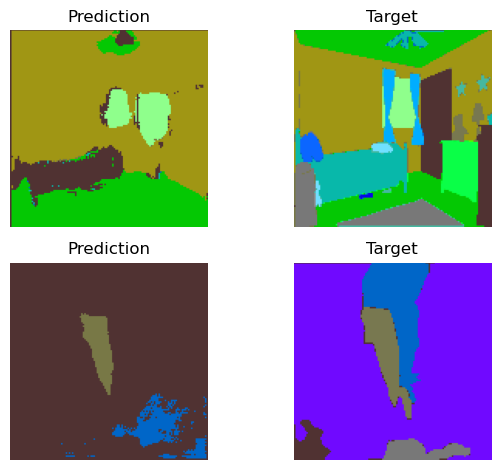

Epoch 2:   4%|▍         | 65/1599 [00:59<12:44,  2.01batch/s, Loss=2.17, Pixel Accuracy=0.367, mIoU=0.00676]  

In [7]:
from Training.trainer import train_fn

scaler = torch.cuda.amp.GradScaler()

start_epoch += 1 # start from the next epoch
print(f"Starting from epoch {start_epoch}")
for epoch in range(start_epoch, NUM_EPOCHS + 1):
    predictions, masks, loss, _ = train_fn(epoch, train_loader, model, optimizer, loss_fn, scaler, device=DEVICE)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
        "epoch": epoch,
    }
    print(f"=> Epoch {epoch} is complete")
    save_checkpoint(checkpoint, filename=CHECKPOINT_FIlE)

    #plot some examples to see how well the model is doing with matplotlib

    import matplotlib.pyplot as plt

    try:

        """Plotting the first prediction and target"""

        predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
        predictions = predictions.unsqueeze(1)
        masks = masks.unsqueeze(1)

        plt.subplot(2, 2, 1)
        plt.imshow(decode_mask(predictions[0][0].cpu().detach().numpy()))
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(decode_mask(masks[0][0].cpu().detach().numpy()))
        plt.title('Target')
        plt.axis('off')

        # Plotting the second prediction and target
        plt.subplot(2, 2, 3)
        plt.imshow(decode_mask(predictions[1][0].cpu().detach().numpy()))
        plt.title('Prediction')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(decode_mask(masks[1][0].cpu().detach().numpy()))
        plt.title('Target')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")
        continue


# Test Prediction

In [ ]:
import sys
sys.path.append('../')

import torch
from Models.unet import UNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the model from the checkpoint
NUM_CLASSES = 35
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_FIlE = "h:\\Downloads\\cityscapes_Unet (3).pth"

model = UNet(out_channels=NUM_CLASSES)
checkpoint = torch.load(CHECKPOINT_FIlE)
print(checkpoint["epoch"])
model.load_state_dict(checkpoint["state_dict"])
# print(checkpoint["epoch"])
model.eval()

transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=1.0,), # Example normalization values
    ToTensorV2()
])

# Load and preprocess the image
image_dir = "F:/UNI_STUFF/Thesis/cityscapes_data/val_images/109.jpg"
mask_dir = "F:/UNI_STUFF/Thesis/cityscapes_data/val_encoded_masks/109.jpg"

image = np.array(Image.open(image_dir).convert("RGB"))
image = transform(image=image)["image"]

# input_tensor = val_transforms(image=image)["image"].unsqueeze(0)

model = model.to(DEVICE)
image = image.unsqueeze(0).to(DEVICE)

# Make predictions

with torch.no_grad():
    predictions = model(image)

# Process the predictions as needed
# ...

# Print the predictions
predictions = torch.argmax(torch.nn.Softmax(dim=1)(predictions), dim=1)
predictions = predictions.squeeze(0).cpu().numpy()



100


Decode the predictions to RGB

<Figure size 640x480 with 0 Axes>

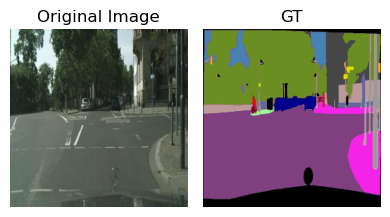

<Figure size 640x480 with 0 Axes>

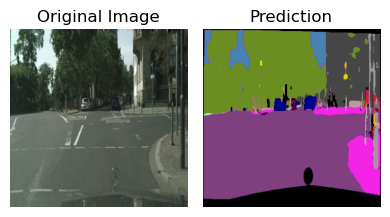

In [ ]:
from Visualizer import plot_images

image_to_display = image.to('cpu')[0].permute(1, 2, 0).numpy()
image_to_display = (image_to_display).astype(np.uint8)
masks = np.array(Image.open(mask_dir))
masks = decode_mask(masks)
prediction_to_display = decode_mask(predictions)
prediction_to_display = prediction_to_display.astype(np.uint8)

plot_images([image_to_display, masks], ['Original Image', 'GT'], max_cols=3, figsize=(4, 3))
plot_images([image_to_display, prediction_to_display], ['Original Image', 'Prediction'], max_cols=3, figsize=(4, 3))
